In [1]:
import datajoint as dj

# url: http://ucsd-demo-helium.datajoint.io/
# host: ucsd-demo-db.datajoint.io
# 

In [11]:
import os, sys
sys.path.append('./lib')
from utilities import *
from initialization_of_db import *

# %%writefile setup/credFiles.yaml
# aws_fp: /mnt/c/Users/Alex/Documents/json_credentials/alex_aws_credentials.json
# dj_fp: /mnt/c/Users/Alex/Documents/json_credentials/datajoint_db_credentials.json

dj_creds = get_dj_creds()
dj.config['database.user'] = dj_creds['user']
dj.config['database.password'] = dj_creds['passwd']
dj.config['database.host'] =  dj_creds['host']
dj.config['database.port'] = dj_creds['port']
dj.config.save_local()

# Connect to datajoint server
dj.conn()

SyntaxError: invalid syntax (<ipython-input-11-b1c383e1cc55>, line 7)

In [2]:
dj.config['database.host'] = "ucsd-demo-db.datajoint.io"
dj.config['database.user'] = "litao"
dj.config['database.password'] = "One2Three4"

dj.conn()

Connecting litao@ucsd-demo-db.datajoint.io:3306


DataJoint connection (connected) litao@ucsd-demo-db.datajoint.io:3306

In [7]:
# Define which schema you're using
#schema = dj.schema('litao_common_atlas_test')
schema = dj.schema('common_atlas_schema_v0.1')

@schema
class Animal(dj.Manual):
    definition = """
    animal : char(20)                   # Name for lab mouse/rat, max 20 chars, primary key
    ---
    performance_center : enum("", "CSHL", "Salk", "UCSD", "HHMI")
    date_of_birth      : date           # (date) the mouse's date of birth
    species            : enum("mouse", "rat")
    strain             : varchar(50)
    sex                : enum("M", "F") # (M/F) either 'M' for male, 'F' for female
    genotype           : varchar(100)   # transgenic description, Usually "C57"
    breeder_line       : varchar(100)
    tissue_source      : enum("", "animal", "brain", "slides")
    vender             : varchar(100)   # if not from a performance center
    ship_date          : date
    shipper            : enum("", "FedEx", "UPS")
    tracking_number    : varchar(100)
    aliases_1          : varchar(100)   # names given by others
    aliases_2          : varchar(100)   # names given by others
    aliases_3          : varchar(100)   # names given by others
    comments           : varchar(2001)  # assessment
    """

@schema
class Injection(dj.Manual): # Viral injections
    definition = """
    -> Animal
    ---
    performance_center  : enum("", "CSHL", "Salk", "UCSD", "HHMI")
    anesthesia          : enum("", "ketamine", "isoflurane")
    virus               : varchar(100)  # example 'G-pseudo-typed lenti-cre'; multiple rows for Virus, one for each agent
    dye                 : varchar(100)
    method              : enum("", "iontophoresis", "pressure", "volume")
    pipet               : enum("", "glass", "metal")
    concentration_units : float         # if applicable
    titer               : float         # if applicable
    concentration       : float         # if applicable
    location            : varchar(20)   # examples: muscle, brain region
    brain_location_dv   : float         # dorsal-ventral relative to Bregma
    brain_location_ml   : float         # medial-lateral relative to Bregma; check if positive
    brain_location_ap   : float         # anterior-posterior relative to Bregma
    date                : date
    goal                : varchar(2001)
    comments            : varchar(2001) # assessment
    """

@schema
class Label(dj.Manual):
    definition = """
    label_id               : varchar(20)
    ---
    type                   : enum("", "counterstain","FP", "antibody", "organic dye")
    type_of_counterstain   : enum("", "thionon", "NtB", "NtFR", "DAPI", "Giemsa", "Syto41") # NtB = Neurotrace blue; NtFR = Neurotrace far red
    details_of_label       : varchar(200)                                                   # only if not a counterstain
    tranmission            : enum("yes", "no")
    tranmission_wavelength : int
    excitation_wavelength  : int
    excitation_range       : int
    dichroic_cut           : int
    emission_wavelength    : int
    emission_range         : int
    comments               : varchar(2001)                                                  # assessment
    """

@schema
class Histology(dj.Manual):
    definition = """
    -> Animal
    ---
    -> Label
    performance_center      : enum("", "CSHL", "Salk", "UCSD", "HHMI")   # default population is from Injection
    anesthesia              : enum("", "ketamine", "isoflurane", "pentobarbital", "fatal plus")
    perfusion_age_in_days   : tinyint unsigned
    perfusion_date          : date
    perfusion_method        : enum("", "standard", "special")            # standard is DK laboratory SOPXX
    special_perfusion_notes : varchar(200)
    post_fixation_period    : tinyint unsigned
    whole_brain             : enum("Y", "N")
    block                   : varchar(200)                               # if applicable
    date_frozen             : date                                       # if applicable
    date_sectioned          : date
    sectioning_method       : enum("", "cryoJane", "cryostat", "vibratome", "optical")
    section_thickness       : tinyint unsigned
    orientation             : enum("coronal", "horizontal", "sagittal", "oblique")
    oblique_notes           : varchar(200)
    mounting                : enum("every section", "2nd", "3rd", "4th") # used to automatically populate Placeholder
    comments                : varchar(2001)                              # assessment
    """

@schema 
class ScanRun(dj.Manual):
    definition = """
    scan_id            : varchar(20)                              # primary key; assigned here; characters and numbers
    ---
    performance_center : enum("", "CSHL", "Salk", "UCSD", "HHMI") # default population is from Histology
    -> Animal                                                     # multiple rows for Animal IDs, one for each ID
    machine            : enum("", "Zeiss", "Axioscan", "Nanozoomer")
    objective          : enum("60X", "40X", "20X", "10X")
    resolution         : float                                    # lateral resolution if available
    number_of_slides   : int
    date: date
    file_type          : enum("CZI", "JPEG2000", "NDPI", "NGR")
    channels_per_slide : enum("1", "2", "3", "4")
    comments           : varchar(2001)  # assessment
    """

@schema
class Slides(dj.Imported): # prior to segregation of animals and scenes on each slide
    definition = """
    -> ScanRun
    slide_id         : int           # primary key; one per slide; assigned here; integer
    ---
    brains_per_slide : enum("1", "2", "3", "4")
    scenes_per_slide : enum("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12")
    scene_schema     : varchar(200)  # from left to right, top to bottom. Example [[2,1],[4,3]]
    path             : varchar(200)  # example: ".\...name1"_"name2"_..._"slide number"_"date".CZI and ".\...ScanID"_"Slide_ID".CZI
    comments         : varchar(2001) # assessment
    """

@schema 
class Section(dj.Imported):
    definition = """
    -> Animal
    section_number : int            # this can be reverse ordered for flipped directions of cutting. 
    ---
    -> Slides
    scene_number   : int            # this ordered is manually entered.
    path           : varchar(200)   # example: name1_name2_..._"slide number"_"date"_"scene number"_"section number".tif, 
                                    # "Animal ID"_"ScanID"_"slide number"_"Section number".tif;
    placeholder    : enum("Y", "N") # used for a missing section
    comments       : varchar(2001)  # assessment
    """

@schema 
class Channels(dj.Imported):
    definition = """
    -> Section 
    channel_number : enum("1", "2", "3", "4") 
    ---
    -> Label
    path           : varchar(200)  # proposed "Animal ID"_"Section number"_"channel".tiff) post extraction by preprocessing
    comments       : varchar(2001) # assessment
    """
    
@schema 
class Contours(dj.Imported):
    definition = """
    -> Section
    ------------------
    snake_contours : varchar(200) # list of polygons to set-up mask at selected sections
                                  # example filename is "STACK_prep1_thumbnail_initSnakeContours.pkl"
    """

AccessError: ('Insufficient privileges.', "Access denied for user 'litao'@'%' to database 'common_atlas_schema_v0.1'", 'CREATE DATABASE `common_atlas_schema_v0.1`')

Note:
1. All invalid symbols and characters contained within these symbols in the attribute name are removed.
2. All class names are CamelCase and attribute names are lowercase connected by underscores.
3. Line 53: Label_ID is assumed to be varchar(20)
4. filepath is changed to be varchar
5. enum(int) is changed to enum(char)

In [9]:
# Example usage
Animal.insert1(['animal', '', '2019-11-24', 'mouse', '', 'M', '', '', '', '', '2019-11-24', '', '', '', '', '', ''])
Label.insert1(['label', '', '', '', 'yes', 0, 0, 0, 0, 0, 0, ''])
Injection.insert1(['animal', '', '', '', '', '', '', 0, 0, 0, '', 0, 0, 0, '2019-11-24', '', ''])
Histology.insert1(['animal', 'label', '', '', 0, '2019-11-24', '', '', 0, 'Y', '', '2019-11-24', '2019-11-24', '', 0, 'coronal', '', '2nd', ''])
ScanRun.insert1(['scanRun', '', 'animal', '', '60X', 0, 0, '2019-11-24', 'CZI', '1', ''])
Slides.insert1(['scanRun', 0, 1, 1, '', 'slide_path', ''], allow_direct_insert=True)
Section.insert1(['animals', 0, 'scanRun', 0, 0, 'section_path', 'Y', ''], allow_direct_insert=True)
Channels.insert1(['animal', 0, '1', 'label', 'channel_path', ''], allow_direct_insert=True)
Contours.insert1(['animal', 0, 'contour_path'], allow_direct_insert=True)

DuplicateError: ("Duplicate entry 'animal' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [22]:
schema.drop()

Proceed to delete entire schema `litao_common_atlas_test`? [yes, No]: yes


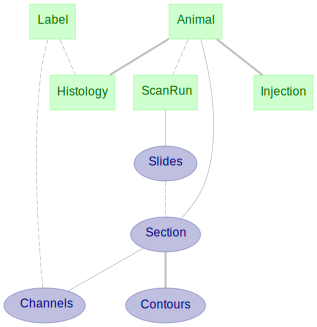

In [10]:
dj.ERD(schema)

In [6]:
animal_name = 'MD594'

performance_center = 'CSHL'
date_of_birth = '01-01-0001'
species = 'mouse'
strain = 'thionin'
sex = 'M'
genotype = ''
breeder_line = ''
tissue_source = 'slides'
vender = ''
ship_date = '01-01-0001'
shipper = ''
tracking_number = ''
aliases_1 = ''
aliases_2 = ''
aliases_3 = ''
comments = 'Used as a foundational brain.'

Animal.insert1([animal_name, performance_center, date_of_birth, 
                species, strain, sex, genotype, breeder_line, 
                tissue_source, vender, ship_date, shipper, tracking_number, 
                aliases_1, aliases_2, aliases_3, comments])

performance_center = 'CSHL'
anesthesia = ''
virus = ''
dye = ''
method = ''
pipet = ''
concentration_units = -1
titer = -1
concentration = -1
location = ''
brain_location_dv = -1
brain_location_ml = -1
brain_location_ap = -1
date = '01-01-0001'
goal = ''
comments = ''

Injection.insert1([animal_name, performance_center, anesthesia, 
                   virus, dye, method, pipet, concentration_units, 
                   titer, concentration, location, brain_location_dv, 
                   brain_location_ml, brain_location_ap, date, goal, comments])

label_id = 'thionin_counterstain'
performance_center = 'CSHL'
anesthesia = ''
perfusion_age_in_days = 0
perfusion_date = '01-01-0001'
perfusion_method = ''
special_perfusion_notes = ''
post_fixation_period = 0
whole_brain = 'Y'
block = ''
date_frozen = '01-01-0001'
date_sectioned = '01-01-0001'
sectioning_method = ''
section_thickness = 20
orientation = 'sagittal'
oblique_notes = ''
mounting = 'every section'
comments = ''

Histology.insert1([animal_name, label_id, performance_center, anesthesia, 
                   perfusion_age_in_days, perfusion_date, perfusion_method, 
                   special_perfusion_notes, post_fixation_period, whole_brain,
                   block, date_frozen, date_sectioned, sectioning_method, section_thickness, 
                   orientation, oblique_notes, mounting, comments])

scan_id = animal_name+'_scan_1'
performance_center = 'CSHL'
machine = 'Nanozoomer'
objective = '60X'
resolution = 0.46
number_of_slides = -1
date = '01-01-0001'
file_type = 'CZI'
Channels_per_slide = 1
comments = ''

ScanRun.insert1([scan_id, performance_center, animal_name, 
                 machine, objective, resolution, number_of_slides, 
                 date, file_type, Channels_per_slide, comments])

In [17]:
animal_name = 'MD585'
performance_center = 'CSHL'
date_of_birth = '01-01-0001'
species = 'mouse'
strain = 'thionin'
sex = 'M'
genotype = ''
breeder_line = ''
tissue_source = 'slides'
vender = ''
ship_date = '01-01-0001'
shipper = ''
tracking_number = ''
aliases_1 = ''
aliases_2 = ''
aliases_3 = ''
comments = 'Used as a foundational brain.'

Animal.insert1([animal_name, performance_center, date_of_birth, 
                species, strain, sex, genotype, breeder_line, 
                tissue_source, vender, ship_date, shipper, tracking_number, 
                aliases_1, aliases_2, aliases_3, comments])

In [20]:
animal_name = 'MD585'
performance_center = 'CSHL'
anesthesia = ''
virus = ''
dye = ''
method = ''
pipet = ''
concentration_units = -1
titer = -1
concentration = -1
location = ''
brain_location_dv = -1
brain_location_ml = -1
brain_location_ap = -1
date = '01-01-0001'
goal = ''
comments = ''

Injection.insert1([animal_name, performance_center, anesthesia, 
                   virus, dye, method, pipet, concentration_units, 
                   titer, concentration, location, brain_location_dv, 
                   brain_location_ml, brain_location_ap, date, goal, comments])

In [33]:
#animal_name = 'MD585'
label_id = 'thionin_counterstain'
label_type = 'counterstain'
type_of_counterstain = 'thionon'
details_of_label = ''
tranmission = 'no'
tranmission_wavelength = -1
excitation_wavelength = -1
excitation_range = -1
dichroic_cut = -1
emission_wavelength = -1
emission_range = -1
comments = ''

Label.insert1([label_id, label_type, type_of_counterstain, 
                details_of_label, tranmission, tranmission_wavelength, 
                excitation_wavelength, excitation_range, 
                dichroic_cut, emission_wavelength, emission_range, comments])

In [35]:
animal_name = 'MD585'
label_id = 'thionin_counterstain'
performance_center = 'CSHL'
anesthesia = ''
perfusion_age_in_days = 0
perfusion_date = '01-01-0001'
perfusion_method = ''
special_perfusion_notes = ''
post_fixation_period = 0
whole_brain = 'Y'
block = ''
date_frozen = '01-01-0001'
date_sectioned = '01-01-0001'
sectioning_method = ''
section_thickness = 20
orientation = 'sagittal'
oblique_notes = ''
mounting = 'every section'
comments = ''

Histology.insert1([animal_name, label_id, performance_center, anesthesia, 
                   perfusion_age_in_days, perfusion_date, perfusion_method, 
                   special_perfusion_notes, post_fixation_period, whole_brain,
                   block, date_frozen, date_sectioned, sectioning_method, section_thickness, 
                   orientation, oblique_notes, mounting, comments])

In [29]:
animal_name = 'MD585'
scan_id = 'scan_1'
performance_center = 'CSHL'
machine = 'Nanozoomer'
objective = '60X'
resolution = 0.46
number_of_slides = -1
date = '01-01-0001'
file_type = 'CZI'
Channels_per_slide = 1
comments = ''

ScanRun.insert1([scan_id, performance_center, animal_name, 
                 machine, objective, resolution, number_of_slides, 
                 date, file_type, Channels_per_slide, comments])

In [ ]:
# #animal_name = 'MD585'
# scan_id = 'scan_1'
# slide_id = ''
# brains_per_slide = ''
# scenes_per_slide = ''
# scene_schema = ''
# path = ''
# comments = ''

# Slides.insert1(['scanRun', 0, 1, 1, '', 'slide_path', ''], allow_direct_insert=True)

In [ ]:
Label.insert1(['label', '', '', '', 'yes', 0, 0, 0, 0, 0, 0, ''])
Section.insert1(['animals', 0, 'scanRun', 0, 0, 'section_path', 'Y', ''], allow_direct_insert=True)
Channels.insert1(['animal', 0, '1', 'label', 'channel_path', ''], allow_direct_insert=True)
Contours.insert1(['animal', 0, 'contour_path'], allow_direct_insert=True)